In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, utils

import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model

import tensorflow_addons as tfa

c:\Users\dream\anaconda3\envs\default\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\dream\anaconda3\envs\default\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
I

In [2]:
df = pd.read_excel("SCUT-FBP5500_v2/All_Ratings.xlsx")
df.head()

,Rater,Filename,Rating,original Rating
0,1,CF1.jpg,3,NaN
1,1,CF10.jpg,3,NaN
2,1,CF100.jpg,1,NaN
3,1,CF101.jpg,2,NaN
4,1,CF102.jpg,3,NaN


In [3]:
df = df.drop(columns="original Rating", axis=1)
df.head()

,Rater,Filename,Rating
0,1,CF1.jpg,3
1,1,CF10.jpg,3
2,1,CF100.jpg,1
3,1,CF101.jpg,2
4,1,CF102.jpg,3


In [4]:
df_y = df.groupby("Filename")["Rating"].mean().reset_index()
file_name = df_y[["Filename"]].to_numpy().flatten()
df_y = df_y["Rating"].to_numpy()

In [5]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """
    이미지를 불러와 전처리합니다.
    img_path: 이미지 경로
    target_size: CNN 입력으로 사용할 이미지의 크기
    """
    path = "SCUT-FBP5500_v2/Images/"
    img = image.load_img(path+img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # 모델에 입력하기 위해 차원을 확장
    return img_array / 255.0  # 이미지를 [0, 1] 범위로 정규화

def load_images(image_filenames, target_size=(224, 224)):
    images = [load_and_preprocess_image(img_path, target_size) for img_path in image_filenames]
    return np.vstack(images)  # 이미지 목록을 하나의 배열로 합치기

In [6]:
# 함수를 사용하여 이미지 데이터를 준비
df_x = load_images(file_name)

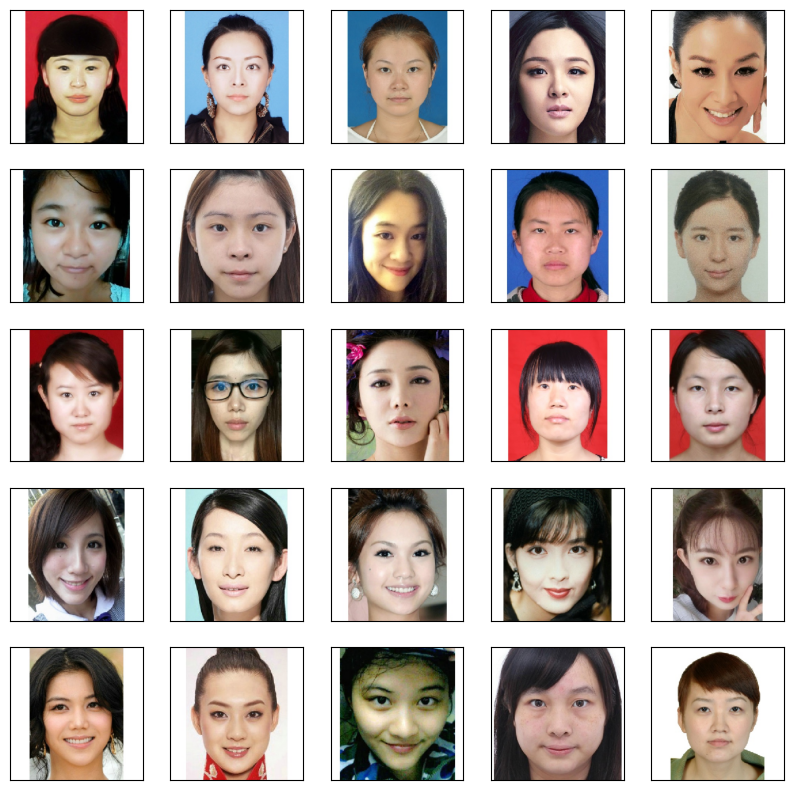

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(df_x[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
plt.show()

In [8]:
df_x.shape

(5500, 224, 224, 3)

In [9]:
df_y = df_y.round()

In [10]:
df_y_cat = utils.to_categorical(df_y.round())[:,1:]

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=1234)
x_train, x_valid, y_train, y_valid  =train_test_split(x_train, y_train, test_size=0.25, random_state=1234)

In [12]:
print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(3300, 224, 224, 3) (1100, 224, 224, 3) (1100, 224, 224, 3)
(3300,) (1100,) (1100,)


In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=None),
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 32)        0

In [14]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

In [15]:
history = model.fit(
    x_train, y_train, batch_size=16,
    epochs=10,)

Epoch 1/10
207/207 [==============================] - 11s 35ms/step - loss: 0.8664
Epoch 2/10
207/207 [==============================] - 7s 33ms/step - loss: 0.8031
Epoch 3/10
207/207 [==============================] - 7s 33ms/step - loss: 0.8136
Epoch 4/10
207/207 [==============================] - 7s 33ms/step - loss: 0.8011
Epoch 5/10
207/207 [==============================] - 7s 33ms/step - loss: 0.8066
Epoch 6/10
207/207 [==============================] - 7s 32ms/step - loss: 0.7972
Epoch 7/10
207/207 [==============================] - 7s 32ms/step - loss: 0.7891
Epoch 8/10
207/207 [==============================] - 7s 32ms/step - loss: 0.7880
Epoch 9/10
207/207 [==============================] - 7s 32ms/step - loss: 0.7750
Epoch 10/10
207/207 [==============================] - 7s 32ms/step - loss: 0.7823


In [16]:
# Evaluate the network
results = model.predict(x_test)

35/35 [==============================] - 5s 28ms/step


In [17]:
results

array([[-0.01121514,  0.02493232,  0.07123887, ..., -0.03543284,
         0.02032307,  0.06819752],
       [-0.08070236,  0.06881747,  0.02563434, ..., -0.05857139,
        -0.03385779,  0.01705931],
       [-0.08364021,  0.06880929,  0.01166745, ..., -0.05406838,
        -0.04291013, -0.00319715],
       ...,
       [-0.08268543,  0.06871182,  0.01590233, ..., -0.05585971,
        -0.03590855,  0.00718085],
       [ 0.03139102, -0.03445737, -0.06703441, ...,  0.04336786,
        -0.01607923, -0.06411178],
       [-0.05538274,  0.0338391 , -0.05183483, ..., -0.02065057,
        -0.05328536, -0.04906661]], dtype=float32)

In [18]:
# Save test embeddings for
# 
import io
np.savetxt("vecs.tsv", results, delimiter='\t')

# out_m = io.open('meta.tsv', 'w', encoding='utf-8')
# for labels in y_test:
#     [out_m.write(str(x) + "\n") for x in labels]
# out_m.close()


try:
  from google.colab import files
  files.download('vecs.tsv')
  files.download('meta.tsv')
except:
  pass